## Purpose 

In this notebook we will explore several datasets in an attempt at providing answers to long debated sprinting questions. The 2 main datasets in use will be the Mens 100m performance by athlete (from [AthleteFirst](https://www.athletefirst.org/wp-content/uploads/2025/06/Mens-100m-by-athlete-20250520.pdf)) and Mens 200m Performances sourced from various Diamond League performances ([such as this](https://www.omegatiming.com/File/000203040102010101FFFFFFFFFFFF49.pdf)) as well as Mens 200m Performances sourced from AthletesFirst (please see the References section in the README for a full list of all resources used)

## Questions/Motivation:
The hope here is twofold: One, to use some data to provide more empirical answers to questions that are often decided by tradition / dogma and Two, selfishly for my own gain a I am a sprinter myself the outcome of this research could provide me some helpful insight into training methods
1. Is there a big difference between 100m and 200m race model? ie curve running notwithstanding, is it beneficial to instruct athletes to run the 200 differently than the 100m?
2. Is there a big difference between what factors affect a good race 100 vs 200 or, are there any measureable factors (reaction time, time to 30m etc) that are more statistically significant in one race over the other?
3. Is speed to a certain meter mark an indicator of success?
4. How does stride length (# of strides) break down for the 100 (avg, distribution etc) and the 200, how do those compare at the 100m mark?
    * Note we will need to use the 100 and 200m combined by athlete data for this
5. How significant is Reaction Time in the 100 (correlated/stat signifigance) and 200? How does it differ between the 2?
    * Note we will need to use the Diamond League data for anything regarding 200m splits at the 10m level of granularity, and the 200m_combined_by_athlete.csv for questions regarding reaction time
6. Is deceleration of a certain % at a certain mark associated with a specific time? 
7. What is more significant in the 200, speed out the blocks or holding off deceleration (speed endurance)? 
8. What is more significant in the 100, speed out of the blocks or holding off deceleration (speed endurance)?


In [2]:
%pip install seaborn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import seaborn as sns
mens_100 = pd.read_csv('Mens_100m_formatted.csv')
mens_100.drop(['Unnamed: 21','Unnamed: 22','Unnamed: 0'],axis=1,inplace=True)

In [4]:
mens_100.columns

Index(['Athlete', 'Meet Info', 'Lane_Place', 'Wind', 'Date', 'RT', '10 m',
       '20 m', '30 m', '40 m', '50 m', '60 m', '70 m', '80 m', '90 m',
       '100 m ', 'Time', '0-30 m', '30-60 m', '60-90 m', 'Stride Rate'],
      dtype='object')

### Times
The times look like a moderately normal distribution, with slight skew right, near bi modal distrbution


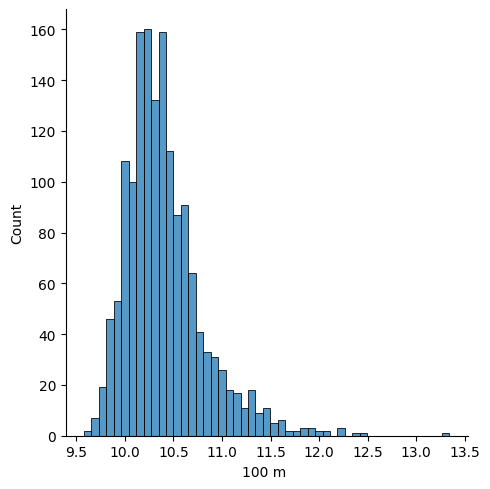

In [5]:
plot = sns.displot(mens_100,x="100 m ")

In [6]:
mens_100['100 m '].describe()

count    1545.000000
mean       10.408395
std         0.407077
min         9.580000
25%        10.140000
50%        10.340000
75%        10.590000
max        13.340000
Name: 100 m , dtype: float64

### Stride Rate
Lets take a look at stride rate, as we can see, it looks like a normalish distribution. We can likely exclude any value less than 40, as its highly unlikely an athlete completed the 100m in less than that. Usain bolt, an athlete with a famously long stride length still came in at 41 strides for his world record performance

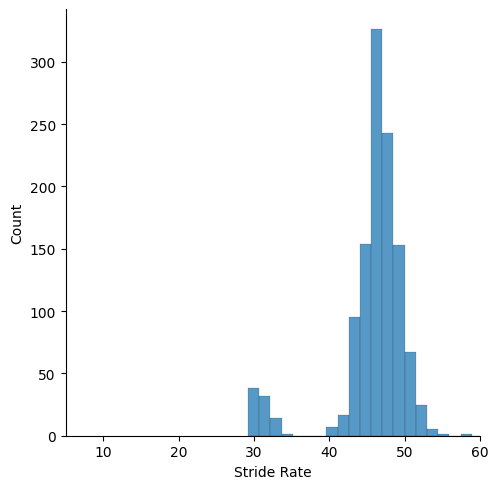

In [7]:
plot = sns.displot(mens_100,x="Stride Rate",bins=300)
plot.set(xlim=(5, 60))

In [8]:
print(mens_100['Stride Rate'].describe())


count    1181.000000
mean       46.291787
std        13.423059
min        29.200000
25%        45.000000
50%        47.000000
75%        48.200000
max       475.000000
Name: Stride Rate, dtype: float64


### Correlation and significance of stride rate and 100m time
* Is stride rate and 100m time correlated?
* If correlated, is stride rate statistically significant? 

In [9]:
# doesnt look great
stride_rate_100m_time = mens_100[['Stride Rate','100 m ']]
stride_rate_100m_time.corr()

,Stride Rate,100 m
Stride Rate,1.000000,0.092723
100 m,0.092723,1.000000


In [10]:
mens_100_no_SR_outliers = mens_100[mens_100['Stride Rate'] > 40]
stride_rate_100m_time = mens_100_no_SR_outliers[['Stride Rate','100 m ']]
stride_rate_100m_time.corr()

,Stride Rate,100 m
Stride Rate,1.000000,0.092415
100 m,0.092415,1.000000


### Lets plot this to see on a scatter
As you can see, massive clustering bottom left

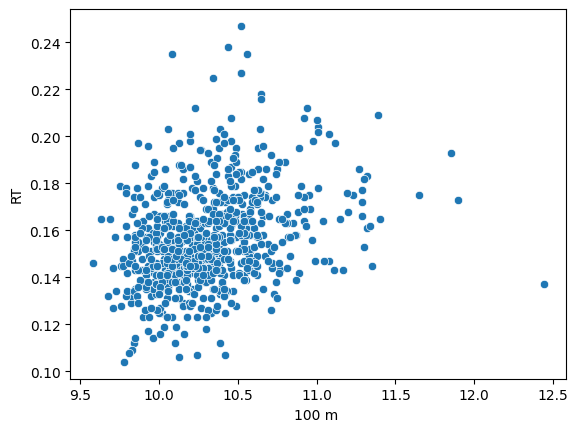

In [11]:
sns.scatterplot(x="100 m ", y="RT", data=mens_100_no_SR_outliers);

### Stride Rate on World Class performances
Many consider a time of <= 10.00s to be "world class". Do we see any relationship between stride length there? Hmm, not so much


In [12]:
men_100m_worldclass = mens_100_no_SR_outliers[mens_100_no_SR_outliers['100 m '] <= 10.0]
stride_rate_100m_time = men_100m_worldclass[['Stride Rate','100 m ']]
stride_rate_100m_time.corr()

,Stride Rate,100 m
Stride Rate,1.0000,0.2165
100 m,0.2165,1.0000


### Reaction Time
Now we can move on to reaction time, it looks somewhat normal, with a slight skew right, and the data seems to confirm that, with the mean being slightly larger than the median. Unfortunately, any hopes we might have had on identifying causal relationship seems at a dead end here too

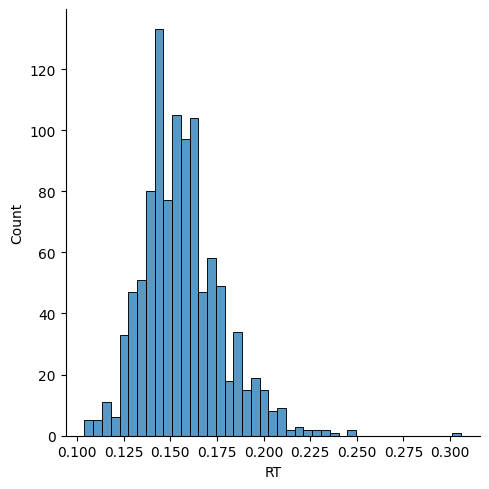

In [13]:
plot = sns.displot(mens_100,x="RT")

In [14]:
print(mens_100['RT'].describe())

count    1041.000000
mean        0.156468
std         0.021748
min         0.104000
25%         0.143000
50%         0.154000
75%         0.167000
max         0.306000
Name: RT, dtype: float64


In [15]:
RT_100m_time = mens_100[['RT','100 m ']]
RT_100m_time.corr()

,RT,100 m
RT,1.000000,0.313821
100 m,0.313821,1.000000


In [16]:
men_100m_worldclass = mens_100[mens_100['100 m '] <= 10.0]
RT_100m_time = men_100m_worldclass[['RT','100 m ']]
RT_100m_time.corr()

,RT,100 m
RT,1.000000,0.072256
100 m,0.072256,1.000000


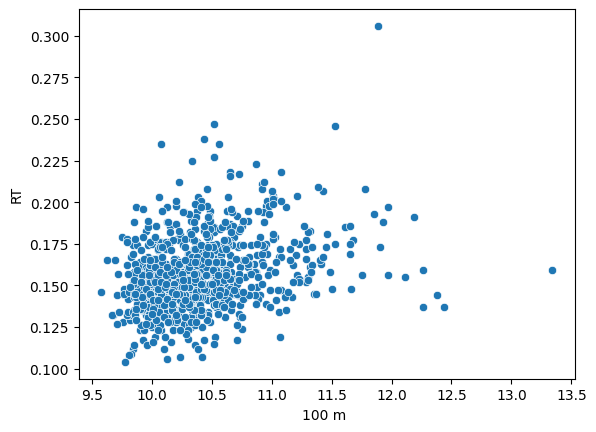

In [17]:
sns.scatterplot(x="100 m ", y="RT", data=mens_100);

### Time splits
Lets move on to identifying if there are any interesting correlaries between time segments. We have every 10m split, so I intend to use them. Lets first plot the distribution of these splits.

Right away we see something super interesting. The distribution density of 10m times are spread out, then approach a much more tight grouping (less variance) up to and including 40m, and then spread out again. This makes sense if you think about it, among athletes, the starts vary wildly, as do their ability to maintain. We see this variance in the first and last splits respectively while nearly all athletes reach very close to a specific speed around 50m given enough time to do so. So now the question is, does it matter who gets there first? Or who can hold it longer? 

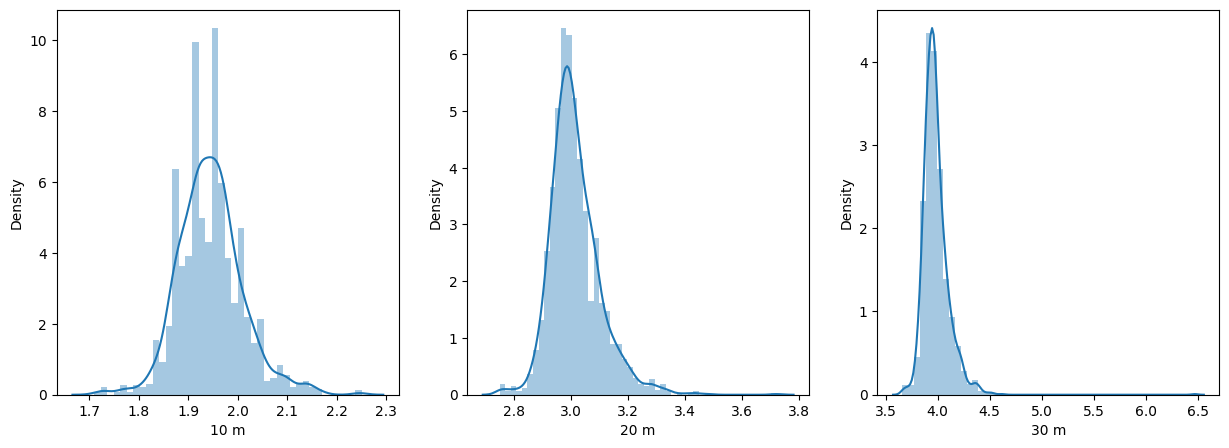

In [18]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(mens_100['10 m'], ax=ax1)
sns.distplot(mens_100['20 m'], ax=ax2)
sns.distplot(mens_100['30 m'], ax=ax3)

plt.show()



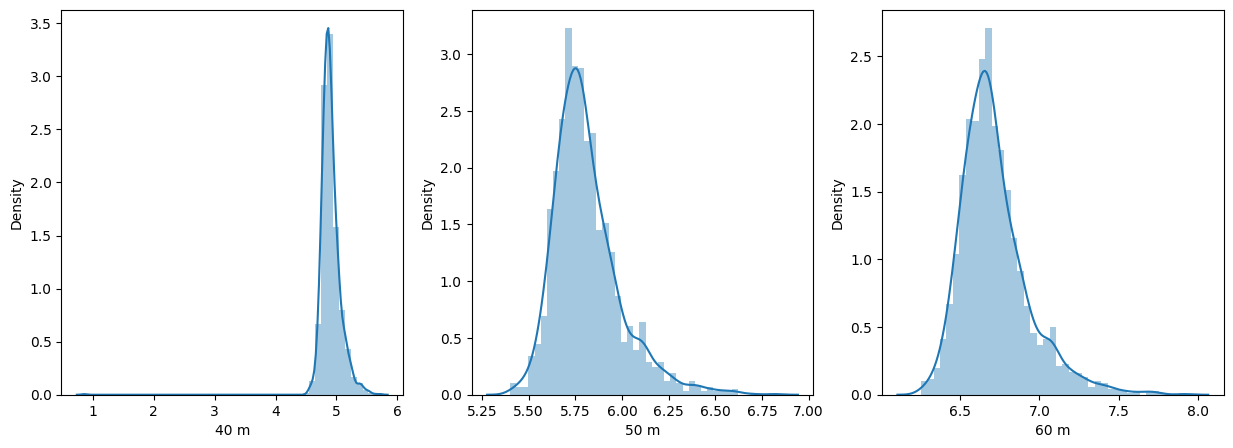

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(mens_100['40 m'], ax=ax1)
sns.distplot(mens_100['50 m'], ax=ax2)
sns.distplot(mens_100['60 m'], ax=ax3)

plt.show()

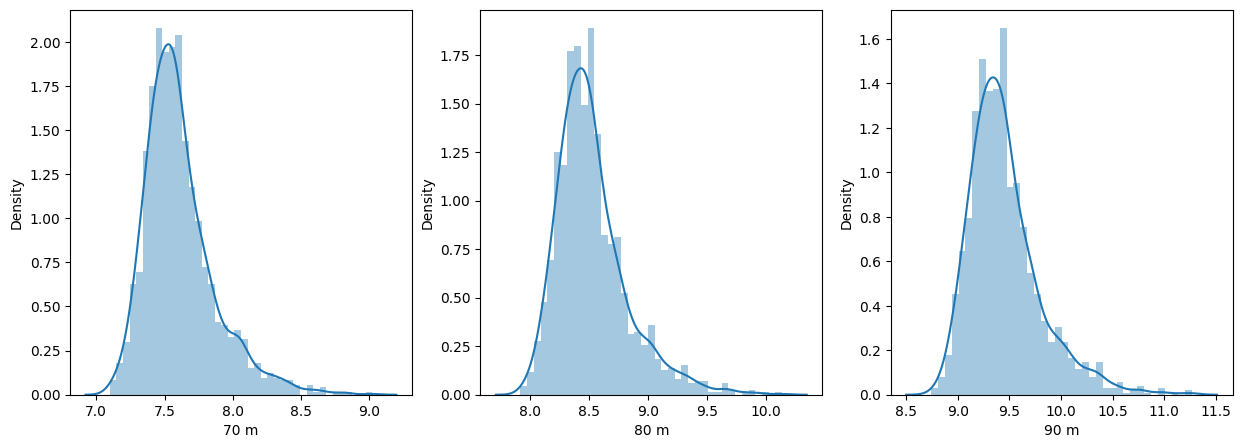

In [20]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.distplot(mens_100['70 m'], ax=ax1)
sns.distplot(mens_100['80 m'], ax=ax2)
sns.distplot(mens_100['90 m'], ax=ax3)

plt.show()

In [47]:
import numpy as np
# gross way of doing it but programmaticaly creating these sucked
fly_frame = mens_100
fly_frame['fly_20']= fly_frame['20 m'] - fly_frame['10 m']
fly_frame['fly_30']= fly_frame['30 m'] - fly_frame['20 m']
fly_frame['fly_40']= fly_frame['40 m'] - fly_frame['30 m']
fly_frame['fly_50']= fly_frame['50 m'] - fly_frame['40 m']
fly_frame['fly_60']= fly_frame['60 m'] - fly_frame['50 m']
fly_frame['fly_70']= fly_frame['70 m'] - fly_frame['60 m']
fly_frame['fly_80']= fly_frame['80 m'] - fly_frame['70 m']
fly_frame['fly_90']= fly_frame['90 m'] - fly_frame['80 m']

fly_frame_corrs = fly_frame[['100 m ','10 m','fly_20','fly_30','fly_40','fly_50','fly_60','fly_70','fly_80','fly_90']]

fly_frame_corrs.corr()

,100 m,10 m,fly_20,fly_30,fly_40,fly_50,fly_60,fly_70,fly_80,fly_90
100 m,1.000000,0.662004,0.753824,0.868600,0.299013,0.315136,0.935928,0.931393,0.929958,0.903580
10 m,0.662004,1.000000,0.372827,0.371625,0.211545,0.200427,0.521242,0.552209,0.540705,0.492204
fly_20,0.753824,0.372827,1.000000,0.732422,0.255171,0.270873,0.695018,0.707653,0.665433,0.596897
fly_30,0.868600,0.371625,0.732422,1.000000,0.282294,0.323741,0.835246,0.823666,0.793426,0.708789
fly_40,0.299013,0.211545,0.255171,0.282294,1.000000,-0.765135,0.296929,0.291785,0.279026,0.258907
fly_50,0.315136,0.200427,0.270873,0.323741,-0.765135,1.000000,0.312688,0.309660,0.294096,0.271774
fly_60,0.935928,0.521242,0.695018,0.835246,0.296929,0.312688,1.000000,0.906892,0.885243,0.831191
fly_70,0.931393,0.552209,0.707653,0.823666,0.291785,0.309660,0.906892,1.000000,0.863706,0.842671
fly_80,0.929958,0.540705,0.665433,0.793426,0.279026,0.294096,0.885243,0.863706,1.000000,0.841675
fly_90,0.903580,0.492204,0.596897,0.708789,0.258907,0.271774,0.831191,0.842671,0.841675,1.000000


### Results!
Interesting! We see increating correlation and then a massive drop off for the 30-40, and 40-50 stretch, but back to increasing correlation (and highly correlated) starting in the 50-60 split range. Our visualizations offer some confirmation at first which again makes sense, the longer the fly split, the slower you are overall. 

But what is happening with fly_40 and 50 ? Well, in the statistical sense it does appear no correlation as in, the athletes fly times here have little effect on their 100m time. But lets think about whats happening here during the race, the athlete is likely at top speed, so t


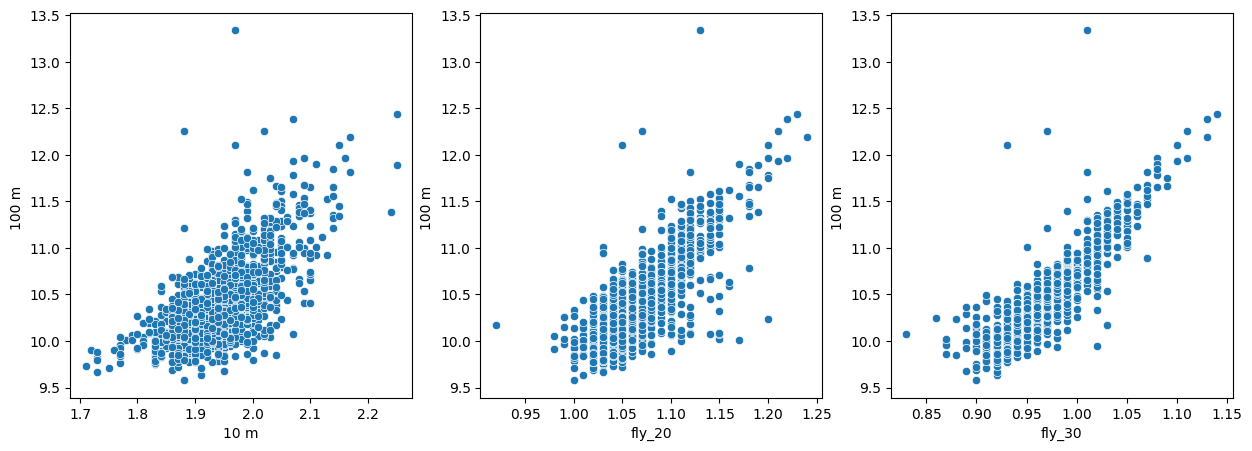

In [51]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['10 m'],y=fly_frame['100 m '], ax=ax1)
sns.scatterplot(x=fly_frame['fly_20'],y=fly_frame['100 m '],ax=ax2)
sns.scatterplot(x=fly_frame['fly_30'],y=fly_frame['100 m '], ax=ax3)

plt.show()

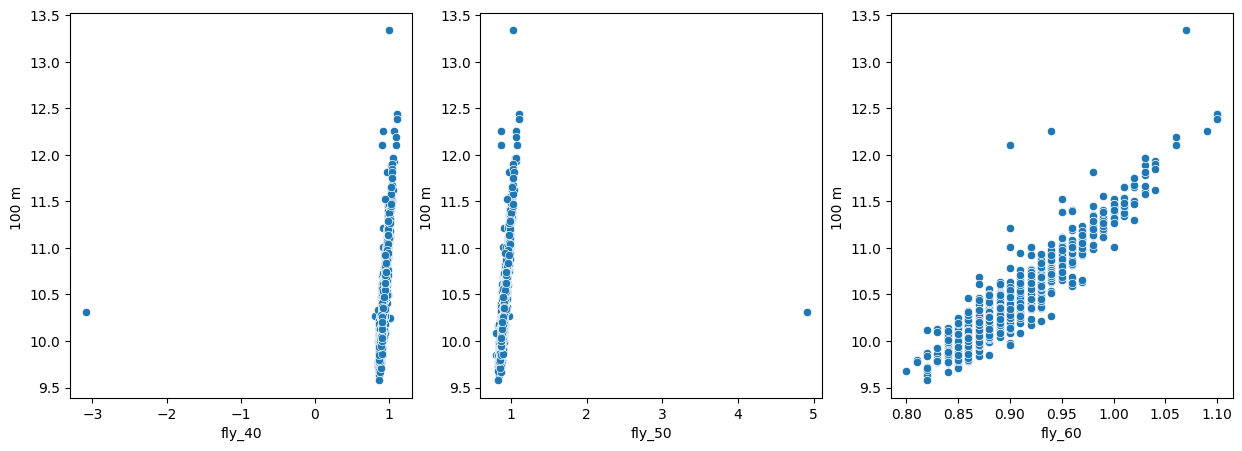

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15, 5))

sns.scatterplot(x=fly_frame['fly_40'],y=fly_frame['100 m '], ax=ax1)
sns.scatterplot(x=fly_frame['fly_50'],y=fly_frame['100 m '],ax=ax2)
sns.scatterplot(x=fly_frame['fly_60'],y=fly_frame['100 m '], ax=ax3)

plt.show()